In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from datetime import datetime

#point-based estimate
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#interval-based estimate
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az

In [100]:
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 5.95605924e+00, 3.46957143e-09, 2.99296531e+02, 5.36128135e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1., 36.84876916, 30.33289918, 156.72063863, 156.06142356],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 15.99371476, 6.8959355, 380.68087314, 387.7069378],
    'e20x32gp411': [12.53828935, 1., 2.78451886, 1.49241488, 8.39069666, 27.77880598, 314.77726787, 311.65818168],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 15.2982435, 11.91592347, 342.96437349, 343.5314864],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 3.4673668, 20.82148359, 307.13693296, 290.48137472],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 26.05989294, 20.59322098, 218.62810381, 218.64413488],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1., 21.72980962, 19.19063999, 277.09322359, 275.39980816],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 22.82771137, 18.70845616, 228.18083668, 227.98611955]
}

In [101]:
class HillFunction:
    
    @staticmethod
    def hill_activation(x, K, n, ymin, ymax):
    
        return ymin + (ymax - ymin) * (x**n / (K**n + x**n))
    
    @staticmethod
    def hill_activation_and(x1, x2, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):

        #x1, x2 = x
        return HillFunction.hill_activation(x1, K1, n1, ymin1, ymax1) * HillFunction.hill_activation(x2, K2, n2, ymin2, ymax2)
    
fluos = pd.read_csv('datasets/induction_matrix/induction_fluo.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]
gate = 'e11x32STPhoRadA'
x1, x2 = np.meshgrid(cumas, aras)
#x = np.vstack((x1.ravel(), x2.ravel()))

fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
y = fluo_t[1440]

beginning = datetime.now()
print('Started at:', beginning)
with pm.Model() as bayesian_model:
    
    sigma = pm.Normal('sigma', y.mean(), 0.5*y.mean())
    K1 = pm.Normal('K1', 2e1, 5)
    K2 = pm.Normal('K2', 2e1, 5)
    n1 = pm.Normal('n1', 5, 1)
    n2 = pm.Normal('n2', 5, 1)
    ymin1 = pm.Normal('ymin1', 50, 5)
    ymin2 = pm.Normal('ymin2', 50, 5)
    ymax1 = pm.Normal('ymax1', 100, 10)
    ymax2 = pm.Normal('ymax2', 100, 10)
    
    y_hat = HillFunction.hill_activation_and(x1.ravel(), x2.ravel(), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    y_pred = pm.Normal('y_hat', y_hat, sigma, observed=y.values)
    
    #step = pm.Metropolis()
    #trace = pm.sample(1000, tune=1000, cores=1, chains=2)

    #data = az.from_pymc3(trace=trace)
    #data.to_netcdf('Marionette-NUTS' + datetime.now().strftime('%Y%m%d') + '.nc')
    
    map_estimate = pm.find_MAP()
    
ending = datetime.now()
print('Finished at:', ending)
print('Execution time:', ending-beginning)

Started at: 2021-08-26 17:09:39.082374



Finished at: 2021-08-26 17:09:44.050005
Execution time: 0:00:04.967631


In [102]:
map_estimate

{'sigma': array(86953.90656546),
 'K1': array(19.4174682),
 'K2': array(19.79630565),
 'n1': array(5.00627037),
 'n2': array(4.9903793),
 'ymin1': array(50.18749863),
 'ymin2': array(50.25055068),
 'ymax1': array(101.58235065),
 'ymax2': array(101.45629069)}

In [105]:
[float(i) for i in list(map_estimate.values())[1:]]

[19.417468199900505,
 19.796305648408687,
 5.006270368883731,
 4.990379304603606,
 50.18749863385959,
 50.25055068229069,
 101.58235065313463,
 101.45629068698557]

In [16]:
with bayesian_model:
    data = az.from_pymc3(trace=trace)
    #data.to_netcdf(gate + '-' + datetime.now().strftime('%Y%m%d') + '.nc')
    
ending = datetime.now()

print('Finished at:', ending)
print('Execution time:', ending-beginning)

Finished at: 2021-08-25 19:45:21.845260
Execution time: 0:00:45.882037


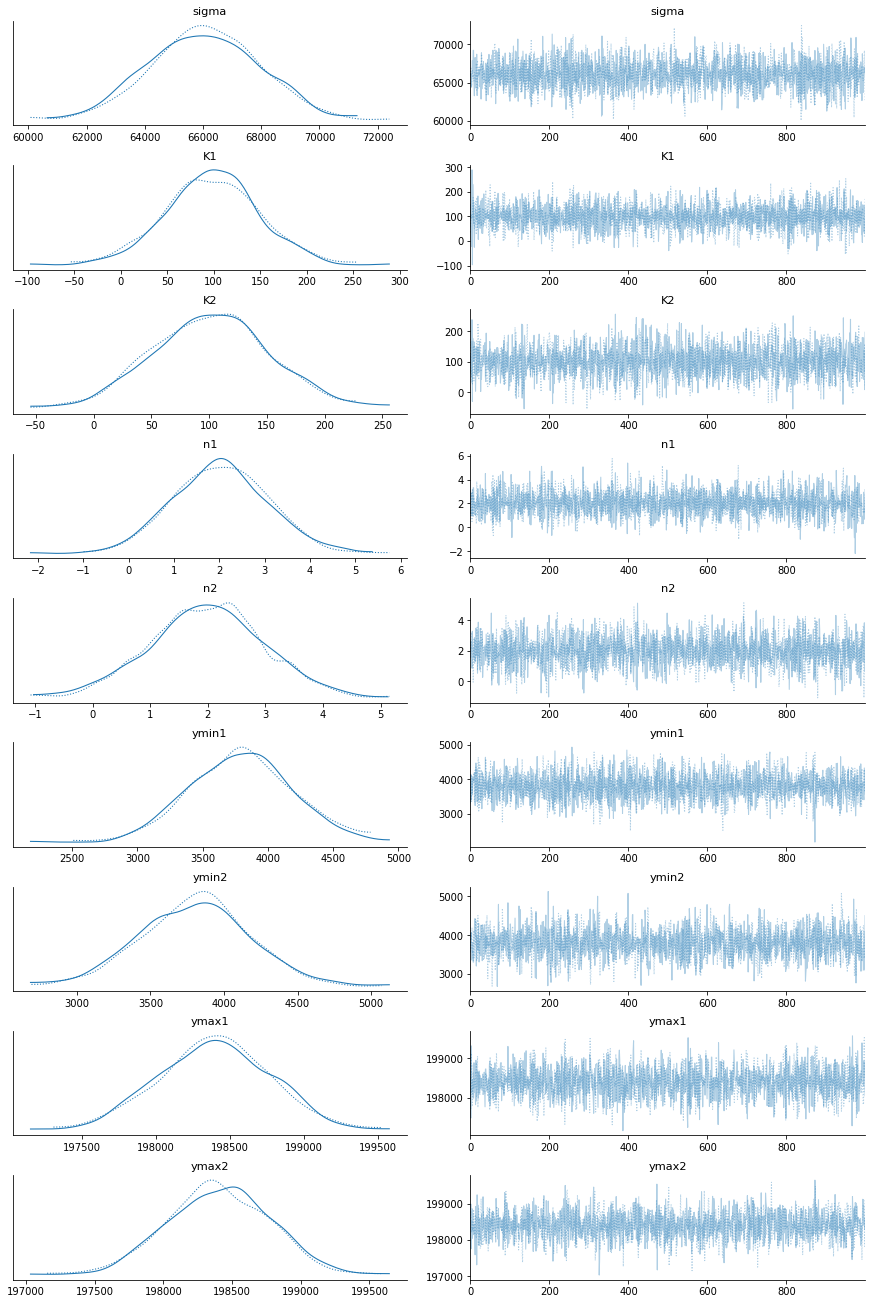

In [17]:
az.plot_trace(data)
sns.despine()

#### ODE Models

In [9]:
#static model
def hill_activation(x, K, n):
    return x**n / (K**n + x**n)

def growth_rate(OD, r, c):
    return (r * (1 - (OD/c)))

#growth curve
def od_inference(t, r, c, y0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(OD[0], r, c) * OD[0]
        return dOD
    
    solution = odeint(od_model, y0, t, (r, c))
    return np.array(solution.T[0])

#model only auto-fluorescence
def gate_wrapper_auto(t, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        Auto, OD = y
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Marionette Strain

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo_half.csv', index_col='time')
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
gates = list(set([i[:-3] for i in fluos.columns.tolist()]))
print(gates)

In [ ]:
sel = 2
gate = gates[sel]
print(sel, gate)
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

fluo = fluo_sel.iloc[:,3]
od = od_sel.iloc[:,3]

#### Point-based Estimation

In [ ]:
par = {
    'alpha': [1e0, 0, 1],
    'beta': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}
o_p0 = [i[0] for i in list(par.values())]
o_bounds = [[i[1] for i in list(par.values())], [i[2] for i in list(par.values())]]
o_params, o_cov = curve_fit(od_inference, od.index, od, bounds=o_bounds)
o_params

In [ ]:
plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *o_params), c='darkgreen')
plt.title(gate)
sns.despine()

#### Interval-Based Estimate (OD)

In [ ]:
class SGNModel:
    
    @staticmethod
    def growth_rate(y, r, c):
        return (r * (1 - (y/c)))
    
    @staticmethod
    def od_model(y, t, p):
        dOD = SGNModel.growth_rate(y[0], p[0], p[1]) * y[0]
        return [dOD]

ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
gates = list(set([i[:-3] for i in ods.columns.tolist()]))
gate = 'e11x32STPhoRadA'
od = ods.loc[:, ods.columns.str.startswith(gate)].iloc[:,3] #take only 11 state

with pm.Model() as od_model:

    r = pm.Uniform('r', 0, 1)
    c = pm.Uniform('c', 0, 2)
    y0 = pm.Uniform('y0', 0, 0.2)

    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.od_model, times=od.index, n_states=1, n_theta=2
    )(y0=[y0], theta=[r, c])

    od_est = pm.Normal('od', mu=y_hat.T[0], sd=0.3, observed=od)

    #approx = pm.fit(method='advi')
    #inference = pm.ADVI()
    #approx = pm.fit(n=5000, method=inference)
    #trace = approx.sample(draws=5000)

    #step = pm.Metropolis()
    #trace = pm.sample(5000, tune=3000, cores=1, chains=3, step=step)
    
    trace = pm.sample(5000, tune=3000, cores=1, chains=2)

    data = az.from_pymc3(trace=trace)
    #data.to_netcdf('datasets/ADVI/OD-' + gate + '-' + datetime.now().strftime('%Y%m%d') + '.nc')

In [ ]:
az.plot_trace(data)
sns.despine()

In [ ]:
mean_pars = []
for p in ['r', 'c', 'y0']:
    mean_pars.append(np.median(trace[p][:,None]))#print(p, trace[p][:,None].mean())
print(mean_pars)

plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *mean_pars), c='darkgreen')
plt.title(gate)
sns.despine()

In [27]:
def plot_trace(params, param_name='parameter', num_cols=2):
    
    num_rows = int(len(params)/num_cols)
    f, ax = plt.subplots(num_rows, num_cols*2, figsize=(7*num_cols, 2*num_rows))
    
    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            
            param = params[i*num_cols+j]
        
            mean = np.mean(param)
            median = np.median(param)
            cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

            ax[i, j*2].plot(param, label='chain-{}'.format(i*num_cols+j))
            ax[i, j*2].axhline(mean, color='r', lw=2, linestyle='--')
            ax[i, j*2].axhline(median, color='c', lw=2, linestyle='--')
            ax[i, j*2].axhline(cred_min, linestyle=':', color='k')
            ax[i, j*2].axhline(cred_max, linestyle=':', color='k')
            ax[i, j*2].legend(loc=1)

            ax[i, j*2+1].hist(param, 30, density=True);
            sns.kdeplot(param, shade=True, ax=ax[i, j*2+1])
            ax[i, j*2+1].axvline(mean, color='r', lw=2, linestyle='--', label='mean')
            ax[i, j*2+1].axvline(median, color='c', lw=2, linestyle='--', label='median')
            ax[i, j*2+1].axvline(cred_min, linestyle=':', color='k', label='95% CI')
            ax[i, j*2+1].axvline(cred_max, linestyle=':', color='k')
            ax[i, j*2+1].set_ylabel(None)
            ax[i, j*2+1].legend(loc=1)
    
    plt.suptitle(param_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [115]:
loaded = az.from_netcdf("datasets/pymc3/Metropolis-Hill-e11x32STPhoRadA-1440.nc")

In [116]:
labels = ['K1', 'K2', 'n1', 'n2', 'ymin1', 'ymin2', 'ymax1', 'ymax2']

In [117]:
thetas = [np.array(loaded['posterior'][label]) for label in labels]

100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


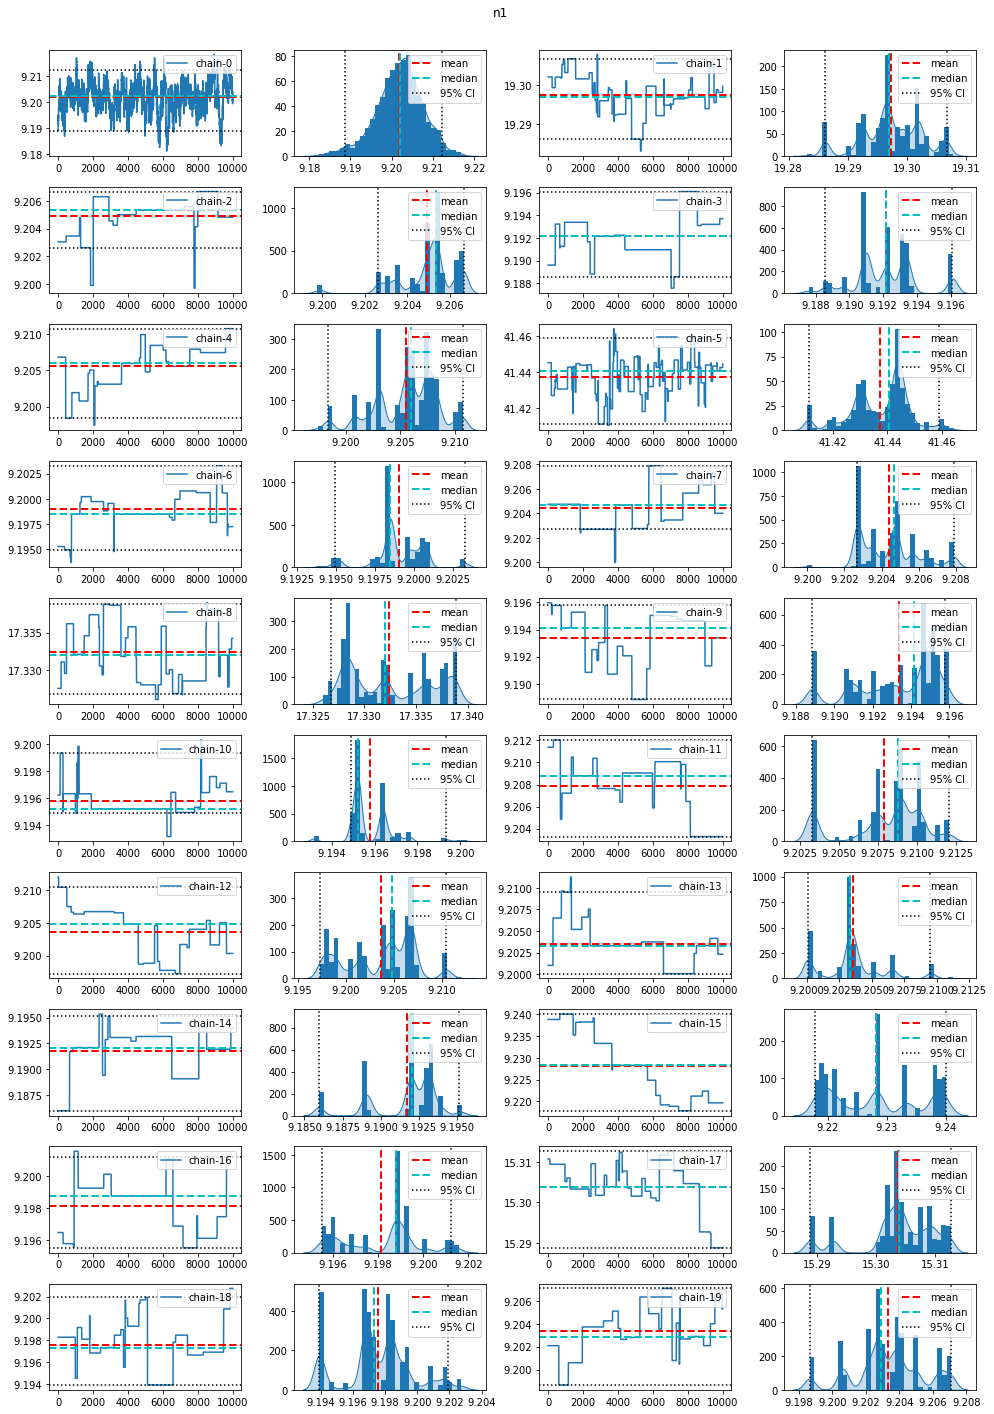

In [120]:
i = 2
plot_trace(thetas[i], labels[i])

In [76]:
chain, idx = 0, 100
popt = [theta[chain][idx] for theta in thetas]
popt

[7.124159695881218,
 3.094046120417713,
 6.974903214423114,
 7.525525482292283,
 3633.638107257998,
 -0.7573799179750833,
 -23321.612346782385,
 -6.004791118620705]

In [ ]:
mean_pars = []
for p in ['r', 'c', 'y0']:
    mean_pars.append(np.array(loaded.posterior[p]).mean())
print(mean_pars)

plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *mean_pars), c='darkgreen')
plt.title(gate)
sns.despine()

In [ ]:
class SGNModel:
    
    @staticmethod
    def growth_rate(y, r, c):
        return (r * (1 - (y/c)))
    
    @staticmethod
    def od_model(y, t, p):
        dOD = SGNModel.growth_rate(y[0], p[0], p[1]) * y[0]
        return [dOD]

ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
gates = list(set([i[:-3] for i in ods.columns.tolist()]))

for gate in gates:
    
    if gate=='blank':
        continue
    
    od = ods.loc[:, ods.columns.str.startswith(gate)].iloc[:,3] #take only 11 state
    
    with pm.Model() as od_model:
    
        r = pm.Uniform('r', 0, 1)
        c = pm.Uniform('c', 0, 2)
        y0 = pm.Uniform('y0', 0, 0.2)

        y_hat = pm.ode.DifferentialEquation(
            func=SGNModel.od_model, times=od.index, n_states=1, n_theta=2
        )(y0=[y0], theta=[r, c])

        od_est = pm.Normal('od', mu=y_hat.T[0], sd=0.3, observed=od)
        
        #approx = pm.fit(method='advi')
        inference = pm.ADVI()
        approx = pm.fit(n=10000, method=inference)
        trace = approx.sample(draws=5000)

        #step = pm.Metropolis()
        #trace = pm.sample(5000, tune=3000, cores=1, chains=3, step=step)
        
        data = az.from_pymc3(trace=trace)
        data.to_netcdf('datasets/ADVI/OD-' + gate + '-' + datetime.now().strftime('%Y%m%d') + '.nc')

In [ ]:
trace2 = trace.sample(draws=5000)
#data = az.from_pymc3(trace=trace)

In [ ]:
data = az.from_pymc3(trace=trace2)

In [ ]:
az.plot_trace(data)
sns.despine()

In [ ]:
data.to_netcdf('datasets/ADVI-' + 'e16x33NrdA2' + '-' + datetime.now().strftime('%Y%m%d') + '.nc')

In [ ]:
az.plot_pair(trace)

#### Interval-Based Estimate (Fluo)

Load OD parameters.

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gates = [g for g in list(set([i[:-3] for i in fluos.columns.tolist()])) if g not in ['positive_control', 'negative_control', 'blank']]

for gate in gates:
    loaded = az.from_netcdf('datasets/bayesian_ods/' + gate + '.nc')

    mean_pars = []
    for p in ['r', 'c', 'y0']:
        mean_pars.append(np.array(loaded.posterior[p]).mean())
    print(gate, mean_pars)

All gates altogether.

In [ ]:
class SGNModel:
    
    @staticmethod
    def hill_activation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def growth_rate(y, a, b):
        return (a * (1 - (y/b)))
    
    @staticmethod
    def gate_model(y, t, p):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y[0], y[1], y[2], y[3], y[4]
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, alpha, beta, _ = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13]
        ind1, ind2 = 1, 1
        
        gamma = SGNModel.growth_rate(OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_activation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]

fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gates = [g for g in list(set([i[:-3] for i in fluos.columns.tolist()])) if g not in ['positive_control', 'negative_control', 'blank']]
fluos_arr = [fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3] for gate in gates]

od_params = {
    'e38x32gp418': [0.014832545686692651, 1.206999008636522, 0.05586756964448041],
    'e20x32gp411': [0.014610032725458771, 1.2772684500977902, 0.04458182544478886],
    'e11x32STPhoRadA': [0.007844653484011118, 1.1134153588014837, 0.10602396117757999],
    'e34x30MjaKlbA': [0.013408372081617236, 1.14628949032757, 0.052259068950788926],
    'e32x30SspGyrB': [0.015133693377991284, 1.151731463297364, 0.04901732064094526],
    'e15x32NpuSspS2': [0.015778141196678447, 1.192983296185405, 0.049950021825183724],
    'e16x33NrdA2': [0.014463894907212425, 1.2421974135452174, 0.055150036439220534],
    'e41x32NrdJ1': [0.013145465488589058, 1.2385872370025641, 0.05941283831303974],
    'e42x32STIMPDH1': [0.012125122999895207, 1.2815026045141547, 0.0524312129470823],
}

with pm.Model() as fluo_model:
    
    y_hats = [None] * len(gates)
    fluo_ests = [None] * len(gates)
    ff = [0] * len(gates)
    hh = [0] * len(gates)
    
    aa = [2 for i in range(9)]
    bb = [2 for i in range(9)]
    c = 2
    dd = [50 for i in range(9)]
    ee = [50 for i in range(9)]
    #ff = [f0, f1, f2, f3, f4, f5, f6, f7, f8]
    gg = [0.05 for i in range(9)]
    #hh = [h0, h1, h2, h3, h4, h5, h6, h7, h8]
    i = 0.05
    jj = [20 for i in range(9)]
    kk = [4 for i in range(9)]
    #r, cc, c0 = 0.007844653484011118, 1.1134153588014837, 0.10602396117757999
    
    for idx in range(len(gates)):
        
        ff[idx] = pm.Uniform('syn_ECF_' + gates[idx], 0, 1e2)
        hh[idx] = pm.Uniform('syn_GFP_' + gates[idx], 0, 1e5)
        
    for idx in range(len(gates)):
        
        r, cc, c0 = od_params[gates[idx]]
        
        y_hats[idx] = pm.ode.DifferentialEquation(
            func=SGNModel.gate_model, times=fluos.index, n_states=5, n_theta=14
        )(y0=[0, 0, 0, 0, c0], theta=[aa[idx], bb[idx], c, dd[idx], ee[idx], ff[idx], gg[idx], hh[idx], i, jj[idx], kk[idx], r, cc, c0])
    
        fluo_ests[idx] = pm.Normal('fluo_' + gates[idx], mu=y_hats[idx].T[0], sd=0.25, observed=fluos_arr[idx])
    
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=1, chains=3, step=step)

A single gate.

In [ ]:
fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gate = 'e11x32STPhoRadA'
fluo = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]
fluo

In [ ]:
import itertools

class SGNModel:
    
    @staticmethod
    def hill_activation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def growth_rate(y, a, b):
        return (a * (1 - (y/b)))
    
    @staticmethod
    def gate_model(y, t, p):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y[0], y[1], y[2], y[3], y[4]
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, alpha, beta, _ = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11], p[12], p[13]
        ind1, ind2 = 1, 1
        
        gamma = SGNModel.growth_rate(OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_activation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]

fluos = pd.read_csv('datasets/marionette_fluo.csv', index_col='time')
gate = 'e11x32STPhoRadA'
fluo = fluos.loc[:, fluos.columns.str.startswith(gate)].iloc[:,3]
pars = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']

od_params = {
    'e38x32gp418': [0.014832545686692651, 1.206999008636522, 0.05586756964448041],
    'e20x32gp411': [0.014610032725458771, 1.2772684500977902, 0.04458182544478886],
    'e11x32STPhoRadA': [0.007844653484011118, 1.1134153588014837, 0.10602396117757999],
    'e34x30MjaKlbA': [0.013408372081617236, 1.14628949032757, 0.052259068950788926],
    'e32x30SspGyrB': [0.015133693377991284, 1.151731463297364, 0.04901732064094526],
    'e15x32NpuSspS2': [0.015778141196678447, 1.192983296185405, 0.049950021825183724],
    'e16x33NrdA2': [0.014463894907212425, 1.2421974135452174, 0.055150036439220534],
    'e41x32NrdJ1': [0.013145465488589058, 1.2385872370025641, 0.05941283831303974],
    'e42x32STIMPDH1': [0.012125122999895207, 1.2815026045141547, 0.0524312129470823],
}

paired_pars = list(itertools.combinations(pars, 2))
for par in paired_pars:

    with pm.Model() as fluo_model:
        
        bn = pm.Uniform('bn', 0, 1e1) if 'bn' in par else 2
        bc = pm.Uniform('bc', 0, 1e1) if 'bc' in par else 2
        bg = pm.Uniform('bg', 0, 1e1) if 'bg' in par else 2
        syn_ECFn = pm.Uniform('syn_ECFn', 0, 1e2) if 'syn_ECFn' in par else 50
        syn_ECFc = pm.Uniform('syn_ECFc', 0, 1e2) if 'syn_ECFc' in par else 50
        syn_ECF = pm.Uniform('syn_ECF', 0, 1e-4) if 'syn_ECF' in par else 1e-7
        syn_GFP = pm.Uniform('syn_GFP', 0, 1e5) if 'syn_GFP' in par else 1e4
        deg = pm.Uniform('deg', 0, 1e-1) if 'deg' in par else 0.05
        deg_GFP = pm.Uniform('deg_GFP', 0, 1e0) if 'deg_GFP' in par else 0.05
        K = pm.Uniform('K', 0, 1e2) if 'K' in par else 2
        n = pm.Uniform('n', 0, 4) if 'n' in par else 2
        
        r, c, c0 = od_params[gate]

        y_hat = pm.ode.DifferentialEquation(
            func=SGNModel.gate_model, times=fluo.index, n_states=5, n_theta=14
        )(y0=[0, 0, 0, 0, c0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, r, c, c0])

        fluo_est = pm.Normal('fluo', mu=y_hat.T[3], sd=0.25, observed=fluo)

        step = pm.Metropolis()
        trace = pm.sample(1000, tune=1000, cores=1, chains=2, step=step)

In [ ]:
pars = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
import itertools
list(itertools.combinations(pars, 2))

In [ ]:
class SGNModel:
    
    @staticmethod
    def od_model(y, t, p):
        dOD = growth_rate(y[0], p[0], p[1]) * y[0]
        return [dOD]
    
    @staticmethod
    def growth_rate(y, r, c):
        return (r * (1 - (y/c)))
    
with pm.Model() as od_model:
    
    r = pm.Uniform('r', 0, 1)
    c = pm.Uniform('c', 0, 2)
    y0 = pm.Uniform('y0', 0, 0.1)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.od_model, times=od.index, n_states=1, n_theta=2
    )(y0=[y0], theta=[r, c])
    
    od_est = pm.Normal('od', mu=y_hat.T[0], sd=0.2, observed=od)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=3000, cores=1, chains=3, step=step)

In [ ]:
data3 = az.from_pymc3(trace=trace)

In [ ]:
data3.to_netcdf('datasets/growth-' + gate + '-1000-3000.nc')

In [ ]:
az.plot_trace(data3)
sns.despine()

In [ ]:
data2 = az.from_pymc3(trace=trace)

In [ ]:
data1.to_netcdf('datasets/growth-' + gate + '-1000.nc')
data2.to_netcdf('datasets/growth-' + gate + '-5000.nc')

In [ ]:
az.plot_trace(data2)
sns.despine()

In [ ]:
mean_pars = []
for p in ['r', 'c', 'y0']:
    mean_pars.append(np.median(trace[p][:,None]))#print(p, trace[p][:,None].mean())
print(mean_pars)

plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *mean_pars), c='darkgreen')
plt.title(gate)
sns.despine()

In [ ]:
data1 = az.from_pymc3(trace=trace)

In [ ]:
az.plot_trace(data1)
sns.despine()

In [ ]:
az.plot_autocorr(data1)
plt.show()

In [ ]:
class SGNModel:
    
    @staticmethod
    def od_model(y, t, p):
        dOD = growth_rate(y[0], p[0], p[1]) * y[0]
        return [dOD]
    
    @staticmethod
    def growth_rate(y, r, c):
        return (r * (1 - (y/c)))
    
def growth_rate(OD, r, c):
    return (r * (1 - (OD/c)))

def test_func(OD, t, r, c):
    dOD = growth_rate(OD[0], r, c) * OD[0]
    return dOD

#growth curve
def od_inference(t, r, c, y0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(OD[0], r, c) * OD[0]
        return dOD
    
    solution = odeint(od_model, y0, t, (r, c))
    return np.array(solution.T[0])

with pm.Model() as od_model:
    
    r = pm.Uniform('r', 0, 1)
    c = pm.Uniform('c', 0, 2)
    y0 = pm.Uniform('y0', 0, 0.1)
    
    y_hat = od_inference(od.index, r, c, y0)
    
    od_est = pm.Normal('od', mu=y_hat, sd=0.2, observed=od)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

In [ ]:
def hill_equation(x, K, n):
        return x**n / (K**n + x**n)

def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, y0):
    
    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP = y
        ind1, ind2 = 1, 1
        
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def model_fit(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n):
    
    fit = gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, [0, 0, 0, 0])
    return pd.Series(fit[3])

In [ ]:
class SGNModel:
    
    @staticmethod
    def hill_equation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def gate_model_no_auto(y, t, p):
        
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10]
        ECFn, ECFc, ECF, GFP = y[0], y[1], y[2], y[3]
        ind1, ind2 = 1, 1
        
        #gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        #dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]

with pm.Model() as od_model:
    
    bn = 2#bn = pm.Uniform('bn', 0, 1e1)
    bc = 2#bc = pm.Uniform('bc', 0, 1e1)
    bg = 2#bg = pm.Uniform('bg', 0, 1e1)
    syn_ECFn = 50#syn_ECFn = pm.Uniform('syn_ECFn', 0, 1e2)
    syn_ECFc = 50#syn_ECFc = pm.Uniform('syn_ECFc', 0, 1e2)
    syn_ECF = pm.Uniform('syn_ECF', 0, 1e2)
    syn_GFP = pm.Uniform('syn_GFP', 0, 1e2)
    deg = 0.05#deg = pm.Uniform('deg', 0, 1e5)
    deg_GFP = 0.05#deg_GFP = pm.Uniform('deg_GFP', 0, 1e0)
    K = 10#K = pm.Uniform('K', 0, 1e2)
    n = 4#n = pm.Uniform('n', 0, 4)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

In [ ]:
data = az.from_pymc3(trace=trace)

In [ ]:
pars = ['syn_ECF', 'syn_GFP']
f, axs = plt.subplots(1, 2, figsize=(8, 2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(pars):
        #ax.hist(trace[pars[i]], bins=30)
        sns.distplot(trace[pars[i]], ax=ax)
        ax.set_title(pars[i])
plt.tight_layout()
sns.despine()

In [ ]:
az.plot_trace(data)
sns.despine()

In [ ]:
class SGNModel:
    
    @staticmethod
    def hill_equation(x, K, n):
        return x**n / (K**n + x**n)
    
    @staticmethod
    def gfp_only_model(y, t, p):
        
        #dependent variables
        Auto, OD = y[0], y[1]
        #a = p[0]
        #alpha, beta = extra
        a, alpha, beta = p[0], p[1], p[2]
        
        gamma = SGNModel.growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dAuto = a - gamma * Auto
        return [dAuto, dOD]
    
    @staticmethod
    def gate_model_no_auto(y, t, p):
        
        bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n = p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10]
        ECFn, ECFc, ECF, GFP = y[0], y[1], y[2], y[3]
        ind1, ind2 = 1, 1
        
        #gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        #dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - deg * ECFn
        dECFc = bc + syn_ECFc * ind2 - deg * ECFc
        dECF = syn_ECF * ECFn * ECFc - deg * ECF
        
        dGFP = bg + syn_GFP * SGNModel.hill_equation(ECF, K, n) - deg_GFP * GFP

        return [dECFn, dECFc, dECF, dGFP]
'''
with pm.Model() as od_model:
    
    #alpha = pm.Uniform('alpha', 0, 1)
    #beta = pm.Uniform('beta', 0, 2)
    #c0 = pm.Uniform('c0', 0, 0.1)
    
    alpha, beta, c0 = o_params
    a = pm.Uniform('a', 0, 200)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gfp_only_model, times=fluo.index, n_states=2, n_theta=3
    )(y0=[0, c0], theta=[a, alpha, beta])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.2, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)
'''

with pm.Model() as od_model:
    
    bn = pm.Uniform('bn', 0, 1e1)
    bc = pm.Uniform('bc', 0, 1e1)
    bg = pm.Uniform('bg', 0, 1e1)
    syn_ECFn = pm.Uniform('syn_ECFn', 0, 1e2)
    syn_ECFc = pm.Uniform('syn_ECFc', 0, 1e2)
    syn_ECF = pm.Uniform('syn_ECF', 0, 1e-4)
    syn_GFP = pm.Uniform('syn_GFP', 0, 1e-1)
    deg = pm.Uniform('deg', 0, 1e5)
    deg_GFP = pm.Uniform('deg_GFP', 0, 1e0)
    K = pm.Uniform('K', 0, 1e2)
    n = pm.Uniform('n', 0, 4)
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, tune=1000, cores=1, step=step)

In [ ]:
pars = {
    'bn': 9.980960e+00,
    'bc': 4.873768e+00,
    'bg': 5.160116e+00,
    'syn_ECFn': 9.989766e+01,
    'syn_ECFc': 5.087405e+01,
    'syn_ECF': 9.844930e-09,
    'syn_GFP': 9.351119e-03,
    'deg': 3.627036e+03,
    'deg_GFP': 1.347098e-01,
    'K': 4.908509e+01,
    'n': 2.490464e+00
}
errs = {
    'bn': 1.282754e-01,
    'bc': 1.242285e+01,
    'bg': 1.022647e+00,
    'syn_ECFn': 4.283182e+00,
    'syn_ECFc': 2.649231e+01,
    'syn_ECF': 1.152230e-08,
    'syn_GFP': 9.366010e-03,
    'deg': 9.459877e-03,
    'deg_GFP': 2.046354e-01,
    'K': 3.432406e+01,
    'n': 2.512038e+00
}

with pm.Model() as od_model:
    
    bn = pm.Normal('bn', mu=pars['bn'], sigma=errs['bn'])
    bc = pm.Normal('bc', mu=pars['bc'], sigma=errs['bc'])
    bg = pm.Normal('bg', mu=pars['bg'], sigma=errs['bg'])
    syn_ECFn = pm.Normal('syn_ECFn', mu=pars['syn_ECFn'], sigma=errs['syn_ECFn'])
    syn_ECFc = pm.Normal('syn_ECFc', mu=pars['syn_ECFc'], sigma=errs['syn_ECFc'])
    syn_ECF = pm.Normal('syn_ECF', mu=pars['syn_ECF'], sigma=errs['syn_ECF'])
    syn_GFP = pm.Normal('syn_GFP', mu=pars['syn_GFP'], sigma=errs['syn_GFP'])
    deg = pm.Normal('deg', mu=pars['deg'], sigma=errs['deg'])
    deg_GFP = pm.Normal('deg_GFP', mu=pars['deg_GFP'], sigma=errs['deg_GFP'])
    K = pm.Normal('K', mu=pars['K'], sigma=errs['K'])
    n = pm.Normal('n', mu=pars['n'], sigma=errs['n'])
    
    y_hat = pm.ode.DifferentialEquation(
        func=SGNModel.gate_model_no_auto, times=fluo.index, n_states=4, n_theta=11
    )(y0=[0, 0, 0, 0], theta=[bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n])
    
    fluo_est = pm.Normal('fluo', mu=y_hat.T[0], sd=0.25, observed=fluo)
    
    #trace = pm.sample(2000, tune=1000, cores=1)
    
    step = pm.Metropolis()
    #trace = pm.sample(2000, tune=1000, cores=1, step=step)
    trace = pm.sample(1000, chains=1, cores=1, step=step)

In [ ]:
data = az.from_pymc3(trace=trace)

In [ ]:
data.to_netcdf('datasets/first-bayesian.nc')

In [ ]:
from datetime import datetime
print('gate' + datetime.now().strftime("%Y%m%d"))

In [ ]:
gates

In [ ]:
pars = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'syn_GFP', 'deg', 'deg_GFP', 'K', 'n']

In [ ]:
f, axs = plt.subplots(2, 6, figsize=(16, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i<len(pars):
        #ax.hist(trace[pars[i]], bins=30)
        sns.distplot(trace[pars[i]], ax=ax)
        ax.set_title(pars[i])
plt.tight_layout()
sns.despine()

In [ ]:
mean_pars = {}
for p in pars:
    mean_pars[p] = trace[p][:,None].mean()#print(p, trace[p][:,None].mean())
mean_pars

#### Load Data

In [ ]:
loaded = az.from_netcdf("datasets/Marionette-20210726.nc")
az.plot_trace(loaded)
sns.despine()

In [ ]:
az.plot_pair(loaded)
sns.despine()

In [ ]:
az.plot_autocorr(loaded)
plt.show()

In [ ]:
loaded = az.from_netcdf('datasets/Marionette-Single-e11x32STPhoRadA-20210723.nc')
az.plot_trace(loaded)
sns.despine()

In [ ]:
az.plot_autocorr(loaded)
plt.show()

In [ ]:
loaded = az.from_netcdf('datasets/e42x32STIMPDH1-20210717-2.nc')
az.plot_trace(loaded)
sns.despine()

In [ ]:
az.plot_posterior(data, round_to=2)

In [ ]:
np.corrcoef(np.array(loaded.posterior['syn_ECF']).flatten(), np.array(loaded.posterior['syn_GFP']).flatten())

In [ ]:
az.plot_autocorr(loaded)
plt.show()

In [ ]:
pars = {
    'bn': 9.980960e+00,
    'bc': 4.873768e+00,
    'bg': 5.160116e+00,
    'syn_ECFn': 9.989766e+01,
    'syn_ECFc': 5.087405e+01,
    'syn_ECF': 9.844930e-09,
    'syn_GFP': 9.351119e-03,
    'deg': 3.627036e+03,
    'deg_GFP': 1.347098e-01,
    'K': 4.908509e+01,
    'n': 2.490464e+00
}
par = list(pars.keys())

In [ ]:
loaded = az.from_netcdf('datasets/ADVI/OD-e16x33NrdA2-20210725.nc')
az.plot_trace(loaded)
sns.despine()

In [ ]:
picked_pars = ['0.1', '1.06', '0.06']

In [ ]:
loaded = az.from_netcdf('datasets/ADVI/OD-e42x32STIMPDH1-20210725.nc')
#az.plot_trace(loaded)
#sns.despine()

mean_pars = []
for p in ['r', 'c', 'y0']:
    mean_pars.append(np.array(loaded.posterior[p]).mean())
mean_pars

In [ ]:
gate = 'e42x32STIMPDH1'
fluo_sel = fluos.loc[:, fluos.columns.str.startswith(gate)]
od_sel = ods.loc[:, ods.columns.str.startswith(gate)]

fluo = fluo_sel.iloc[:,3]
od = od_sel.iloc[:,3]

In [ ]:
plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *mean_pars), c='darkgreen')
plt.title(gate)
sns.despine()

In [ ]:
bn	9.987172e+00	6.260265e+01
1	bc	4.883389e+00	2.852031e+01
2	bg	5.344180e+00	1.805993e+00
3	syn_ECFn	9.999531e+01	4.321537e+01
4	syn_ECFc	5.096548e+01	1.005362e+02
5	syn_ECF	1.581679e-08	7.390481e-08
6	syn_GFP	1.179393e-02	1.144958e-02
7	deg	7.513354e+03	8.551361e-02
8	deg_GFP	2.984798e-02	6.572396e-02
9	K	4.898191e+01	3.087793e+01
10	n	2.563336e+00	1.181155e+01


In [ ]:
fix_par = {'bn': 9.999999999976385,
 'bc': 4.884941174143677,
 'bg': 5.364135672597076,
 'syn_ECFn': 99.9999999999739,
 'syn_ECFc': 50.97696503335078,
 'syn_ECF': 1.576133462199827e-08,
 'syn_GFP': 0.011953121728744096,
 'deg': 7.398089262804092e3,
 'deg_GFP': 3.074861557143704e-2,
 'K': 48.96930082383338,
 'n': 2.5313510745154546}

In [ ]:
mean_pars

In [ ]:
plt.plot(fluo.index, model_fit(fluo.index, *list(mean_pars.values())), label='simulation')
plt.plot(fluo.index, fluo, label='data')
plt.legend()
sns.despine()

In [ ]:
plt.plot(od.index, od_inference(od.index, alpha.mean(), beta.mean(), c0.mean()))
plt.plot(od.index, od)
sns.despine()

#### Load Inference Data

In [4]:
gates = ['e38x32gp418', 'e20x32gp411', 'e11x32STPhoRadA', 'e34x30MjaKlbA', 'e32x30SspGyrB', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e41x32NrdJ1', 'e42x32STIMPDH1']

In [29]:
import itertools
pars = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
paired_pars = list(itertools.combinations(pars, 2))

e15x32NpuSspS2


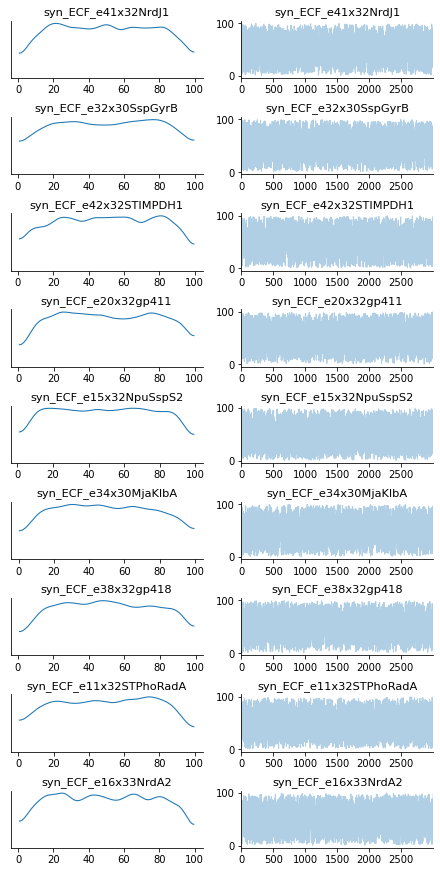

In [74]:
gate = 'e15x32NpuSspS2'
print(gate)
#i = 0
#print(paired_pars[i])
loaded = az.from_netcdf('datasets/bayesian-trial-3/Marionette-20210726.nc')
az.plot_trace(loaded, figsize=(6, 12))
sns.despine()

In [70]:
mean_pars = []
for p in ['r', 'c', 'y0']:
    mean_pars.append(np.array(loaded.posterior[p]).mean())
mean_pars

[0.25289236792086495, 1.043020868500209, 0.06286789442087011]

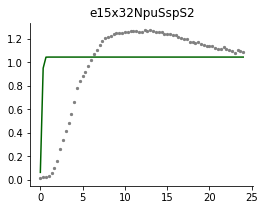

In [71]:
ods = pd.read_csv('datasets/marionette_od.csv', index_col='time')
od = ods.loc[:, ods.columns.str.startswith(gate)].iloc[:,3]

plt.figure(figsize=(4, 3))
plt.scatter(od.index/60, od, c='gray', s=5)
plt.plot(od.index/60, od_inference(od.index, *mean_pars), c='darkgreen')
plt.title(gate)
sns.despine()

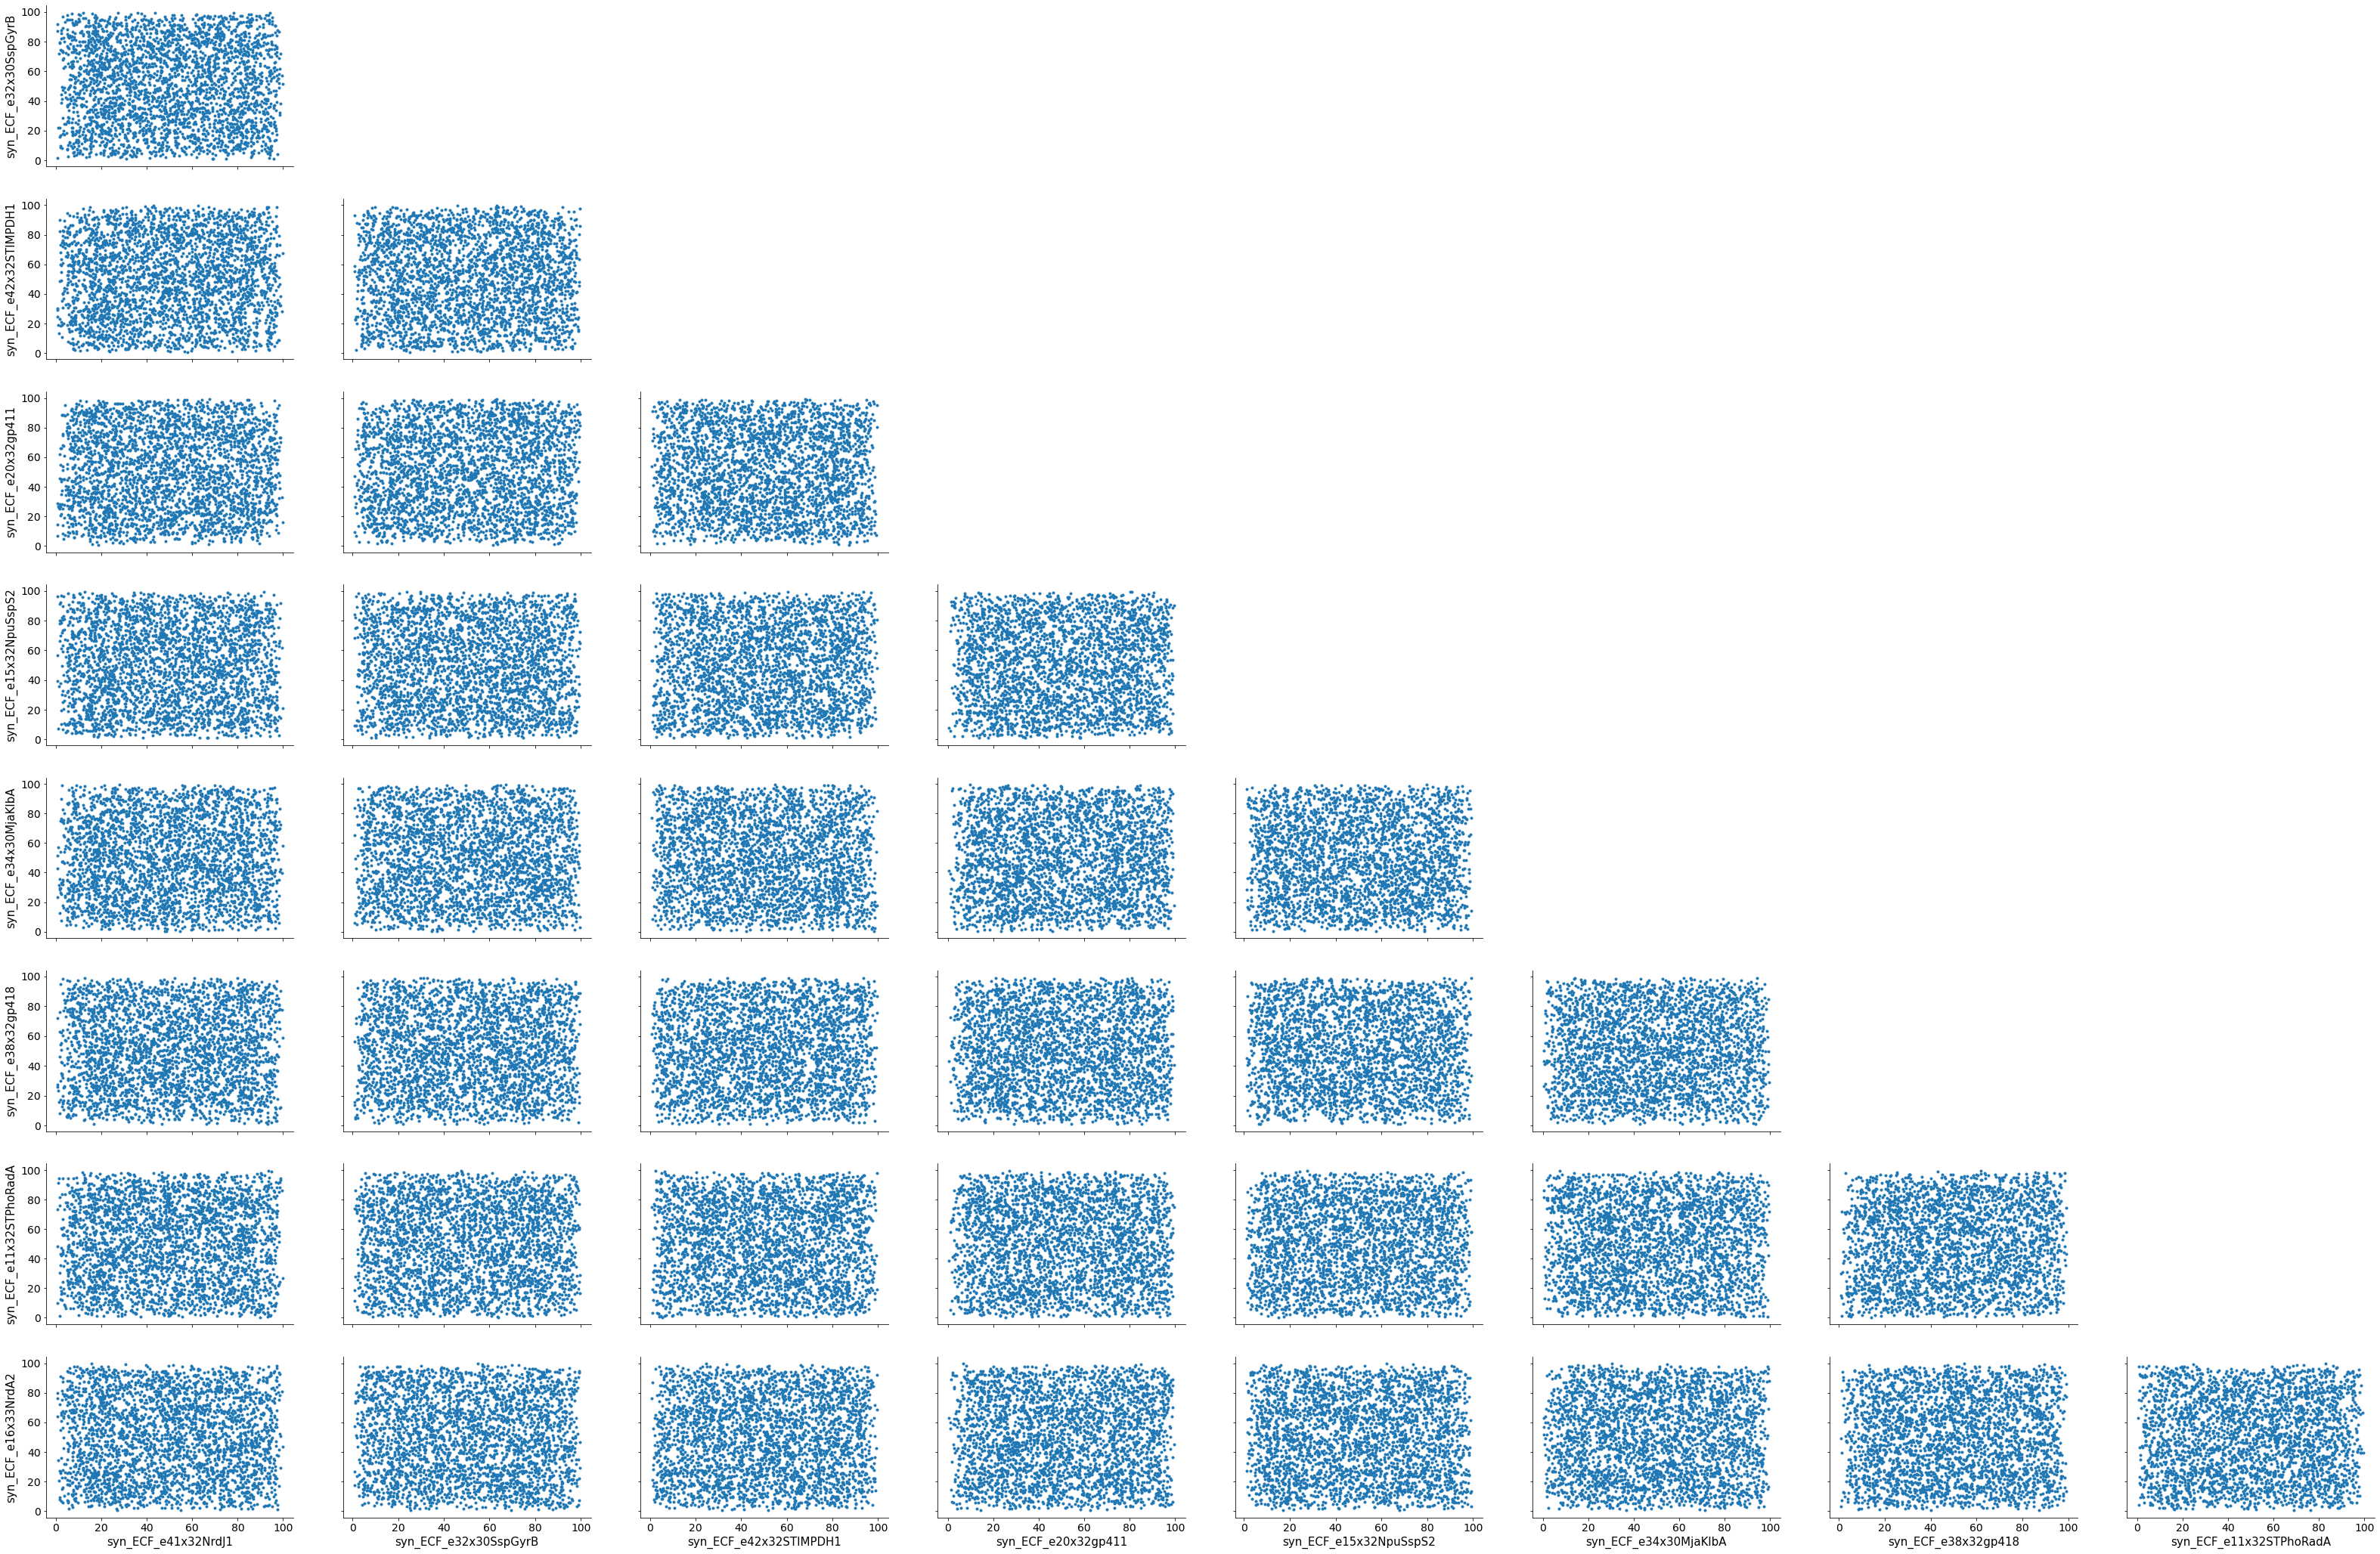

In [75]:
az.plot_pair(loaded)
sns.despine()